In [1]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset using sklearn
from sklearn.datasets import load_boston
data = load_boston()

#Separating data into feature variable X and target variable y respectively
X=data['data']
y=data['target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Extracting the names of the features from data
features = data['feature_names']

#Splitting X & y into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=50)

from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

#Checking the model's performance on the test set
print('R2 score for the model on test set =', reg.score(X_test, y_test))

C:\Users\adity\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

R2 score for the model on test set = 0.9026950583596305


In [2]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=X.shape[0],verbose=1,max_iter=1000, init_params='random',covariance_type='spherical', weight_concentration_prior_type='dirichlet_distribution', random_state=42)
bgmm.fit(X)
print(f"Number of unique clusters = {np.unique(bgmm.predict(X)).shape}")

#Finding cluster labels and probabilities
cluster_labels = bgmm.predict(X)
cluster_proba = bgmm.predict_proba(X)
mu = bgmm.means_
cov = bgmm.covariances_

from pprint import pprint
unique, counts = np.unique(cluster_labels, return_counts=True)
pprint(dict(zip(unique, counts)))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
Number of unique clusters = (13,)
{4: 40,
 12: 20,
 23: 20,
 41: 54,
 108: 21,
 175: 52,
 216: 57,
 242: 15,
 263: 27,
 265: 92,
 273: 10,
 390: 28,
 479: 70}


In [3]:
np.argwhere(cluster_labels==273).ravel()

array([111, 114, 116, 117, 217, 308, 309, 313, 314, 318], dtype=int64)

In [4]:
#Sampling from BGMM
idx = 111
arr = X[idx]

#Finding cluster for the given idx
cluster_label_arr = cluster_labels[idx]
cluster_proba_arr = cluster_proba[idx]
mu_arr = mu[cluster_label_arr]
cov_arr = cov[cluster_label_arr]

#from scipy.stats import multivariate_normal
from scipy.stats import multivariate_normal
distr = multivariate_normal(cov = cov_arr, mean = mu_arr)
X_surrogate = distr.rvs(size = 500)
y_surrogate = reg.predict(X_surrogate)

In [5]:
from tqdm import tqdm
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression

bgmm_stability_scores = []
bgmm_fidelity_scores = []

samples_list = list(range(10, 91, 20)) + list(range(100, 1001, 100))
for num_samples in tqdm(samples_list):
    fidelity_score = 0
    scores = []
    for i in range(10):
        distr = multivariate_normal(cov = cov_arr, mean = mu_arr)
        X_surrogate = distr.rvs(size = num_samples)
        y_surrogate = reg.predict(X_surrogate)
        bbox = LinearRegression().fit(X_surrogate, y_surrogate)

        bbox.fit(X_surrogate, y_surrogate)
#         plt.title(f"Iteration{i}, Surrogate fit = {bbox.score(X_surrogate, y_surrogate)}")
#         plt.stem(bbox.coef_/max(bbox.coef_))
#         plt.show()
        scores.append(bbox.coef_/max(bbox.coef_))
        fidelity_score+=bbox.score(X_surrogate, y_surrogate)
    rankings = rankdata(np.array(scores), axis=1)
    m = rankings.shape[0]
    n = rankings.shape[1]
    denom = m ** 2 * (n ** 3 - n)
    S = n * np.var(np.sum(rankings, axis=0))
    bgmm_stability_scores.append(12 * S / denom)
    bgmm_fidelity_scores.append(fidelity_score/10)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  7.00it/s]


In [6]:
from tqdm import tqdm
import lime.lime_tabular

lime_stability_scores = []
lime_fidelity_scores = []
samples_list = list(range(10, 91, 20)) + list(range(100, 1001, 100))
for num_samples in tqdm(samples_list):
    fidelity_score = 0
    scores = []
    for i in range(10):
        explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                            feature_names=features,
                                                            verbose=False, mode='regression')
        exp_lime = explainer_lime.explain_instance(X[idx], 
                                                   reg.predict, 
                                                   num_features=X.shape[1], 
                                                   num_samples=num_samples)
        
#         plt.title(f"Iteration{i}, Surrogate fit = {bbox.score(X_surrogate, y_surrogate)}")
#         plt.stem(bbox.coef_/max(bbox.coef_))
#         plt.show()
        scores.append(np.array(exp_lime.as_list())[:,1].astype('float'))
        fidelity_score+=exp_lime.score
    
    rankings = rankdata(np.array(scores), axis=1)
    m = rankings.shape[0]
    n = rankings.shape[1]
    denom = m ** 2 * (n ** 3 - n)
    S = n * np.var(np.sum(rankings, axis=0))
    lime_stability_scores.append(12 * S / denom)
    lime_fidelity_scores.append(fidelity_score/10)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


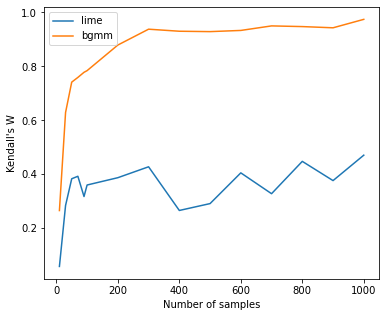

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 6, 5
plt.plot(samples_list,lime_stability_scores,label='lime')
plt.plot(samples_list,bgmm_stability_scores, label='bgmm')
plt.xlabel("Number of samples")
plt.ylabel("Kendall's W")
plt.legend()
plt.savefig("results/stability_boston.png",dpi=300)

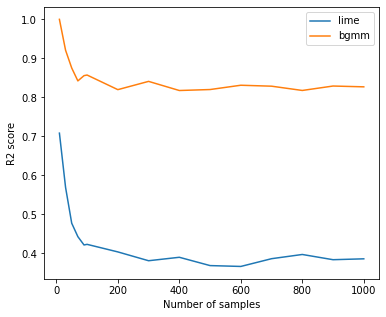

In [8]:
plt.plot(samples_list,lime_fidelity_scores,label='lime')
plt.plot(samples_list,bgmm_fidelity_scores,label='bgmm')
plt.xlabel("Number of samples")
plt.ylabel("R2 score")
plt.legend()
plt.savefig("results/fidelity_boston.png",dpi=300)